In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/dataset_nsfw_lite"

IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 16
SEED = 42
EPOCHS_PHASE1 = 12
EPOCHS_PHASE2 = 15

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 1500 files belonging to 5 classes.
Using 1200 files for training.
Found 1500 files belonging to 5 classes.
Using 300 files for validation.
Classes: ['drawing', 'hentai', 'neutral', 'porn', 'sexy']


In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# ================= LIGHT HEAD =================
inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)

x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# ================= COMPILE =================
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE1,
    callbacks=[early_stop]
)

Epoch 1/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 467s 6s/step - accuracy: 0.2216 - loss: 1.6970 - val_accuracy: 0.3900 - val_loss: 1.5264
Epoch 2/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.2881 - loss: 1.5500 - val_accuracy: 0.5067 - val_loss: 1.4470
Epoch 3/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.3885 - loss: 1.4384 - val_accuracy: 0.5400 - val_loss: 1.3806
Epoch 4/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.4219 - loss: 1.3853 - val_accuracy: 0.5433 - val_loss: 1.3262
Epoch 5/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4689 - loss: 1.3118 - val_accuracy: 0.5467 - val_loss: 1.2786
Epoch 6/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.5284 - loss: 1.2472 - val_accuracy: 0.5600 - val_loss: 1.2351
Epoch 7/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.5300 - loss: 1.2066 - val_accuracy: 0.5767 - val_loss: 1.2047
Epoch 8/12
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.5736 - loss: 1.1628 - val_accuracy: 0.5933

In [ ]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_PHASE2,
    callbacks=[early_stop]
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.6256 - loss: 0.9616 - val_accuracy: 0.6433 - val_loss: 0.8811
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.7002 - loss: 0.7932 - val_accuracy: 0.7067 - val_loss: 0.8193
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.7414 - loss: 0.7069 - val_accuracy: 0.7067 - val_loss: 0.7589
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.7580 - loss: 0.6014 - val_accuracy: 0.7267 - val_loss: 0.7309
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.8264 - loss: 0.5071 - val_accuracy: 0.7233 - val_loss: 0.7031
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8317 - loss: 0.4567 - val_accuracy: 0.7133 - val_loss: 0.7248
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.8857 - loss: 0.3793 - val_accuracy: 0.7200 - val_loss: 0.7086
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8601 - loss: 0.3767 - val_accuracy: 0.

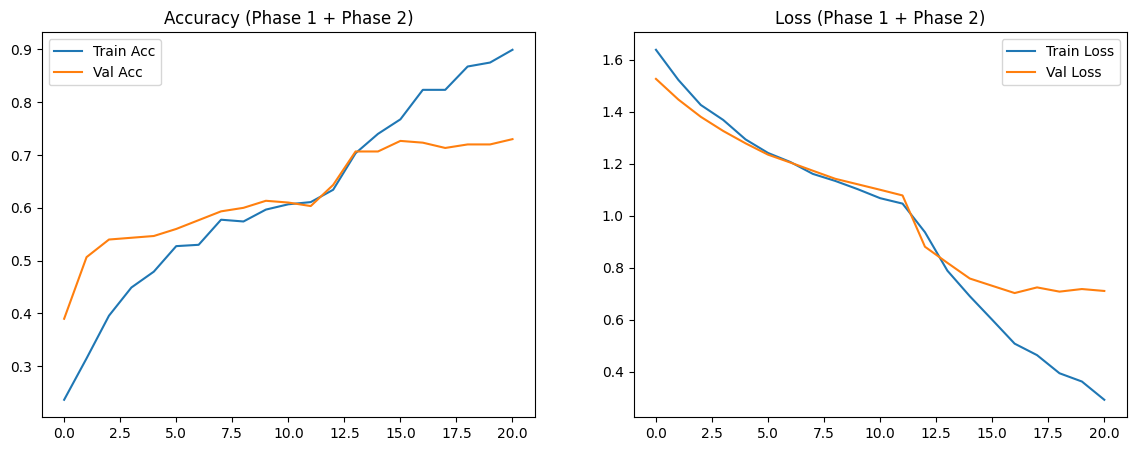

In [ ]:
acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
loss = history.history['loss'] + history_finetune.history['loss']
val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy (Phase 1 + Phase 2)')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Phase 1 + Phase 2)')

plt.show()

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_class = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds_class)

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
              precision    recall  f1-score   support

     drawing       0.78      0.54      0.64        57
      hentai       0.70      0.74      0.72        50
     neutral       0.65      0.84      0.73        64
        porn       0.77      0.83      0.80 